<a href="https://colab.research.google.com/github/amanjaiswal777/BERT_pytorch_multiclass_classification/blob/master/Prediction_on_Saved_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
ls

drive/  sample_data/


In [3]:
cd drive/My Drive/Colab Notebooks/model_selection

/content/drive/My Drive/Colab Notebooks/model_selection


In [4]:
!unzip -q resume_data.zip
print('Unzipped Dataset')

replace resume_data/train_data.xlsx? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace resume_data/test_data.xlsx? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
Unzipped Dataset


In [5]:
!pip install transformers

     |████████████████████████████████| 573kB 4.8MB/s 
     |████████████████████████████████| 3.7MB 52.1MB/s 
     |████████████████████████████████| 1.0MB 50.7MB/s 
     |████████████████████████████████| 890kB 45.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.41-cp36-none-any.whl size=893334 sha256=eb44bb8006329e42026a18510047c269b417b8c8d2a74ac7e930d064346ff525
  Stored in directory: /root/.cache/pip/wheels/22/5a/d4/b020a81249de7dc63758a34222feaa668dbe8ebfe9170cc9b1
Successfully built sacremoses


In [6]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not... we will use CPU
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


In [7]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [8]:
!pip install torch

In [9]:
import pandas as pd
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler


# Load the dataset into a pandas dataframe.
df = pd.read_excel("./resume_data/test_data.xlsx", delimiter='\t')

# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(df.shape[0]))

# df.head()

# Create sentence and label lists
sentences = df.Data.values
labels = df.Class.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 1,491



In [10]:
df.head()

,Data,Class
0,"Long Island, NY, 11731 leah@leahwahab.com (631...",0
1,Leah M. Wahab,0
2,P A T R I C K BL U N T (805)368-7949 ...,0
3,"Thousand Oaks, CA",0
4,* * * * * * * * * *...,0


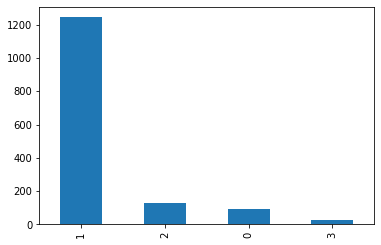

In [11]:
#Distribution of classes
df['Class'].value_counts().plot(kind = 'bar')

In [12]:
import os
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save/'

MODEL_CLASSES = {
    'bert': (BertConfig, BertForSequenceClassification, BertTokenizer),
}
config_class, model_class, tokenizer_class = MODEL_CLASSES['bert']

# Load a trained model and vocabulary that you have fine-tuned
model_1 = model_class.from_pretrained(output_dir)
tokenizer_1 = tokenizer_class.from_pretrained(output_dir)

# Copy the model to the CPU.
model_1.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [13]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model_1.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to CPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model_1(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 1,491 test sentences...
    DONE.


In [0]:
import numpy as np
# For each input batch...
predicted_ones = []
for i in range(len(predictions)):
  
  # The predictions for this batch are a 2-column ndarray (one column for "0" 
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  for i in range(len(pred_labels_i)):
    predicted_ones.append(pred_labels_i[i])

In [0]:
true_ones = []
for i in range(len(true_labels)):
  for j in range(len(true_labels[i])):
    true_ones.append(true_labels[i][j])

In [16]:
right = 0
wrong = 0
for i in range(len(true_ones)):
  if true_ones[i] == predicted_ones[i]:
    right+=1
  else:
    wrong+=1

print(f'Right_Value: {right}, Wrong_value: {wrong}, Total_value: {i+1}')

Right_Value: 1350, Wrong_value: 141, Total_value: 1491


In [17]:
right_accuracy = (right / len(true_ones) ) * 100
print(right_accuracy)

90.54325955734407


In [18]:
wrong_accuracy = (wrong / len(true_ones)) * 100
print(wrong_accuracy)

9.456740442655935


In [0]:
right_0, right_1, right_2, right_3 = 0, 0, 0, 0 #These are the right prediction with different classes present in the test data
for i in range(len(true_ones)):
  if predicted_ones[i]==true_ones[i]==0: #For correct prediction of class 0
    right_0 += 1
  elif  predicted_ones[i]==true_ones[i]==1: #For correct prediction of class 1
    right_1 += 1
  elif  predicted_ones[i]==true_ones[i]==2: #For correct prediction of class 2
    right_2 += 1
  elif  predicted_ones[i]==true_ones[i]==3: #For correct prediction of class 3
    right_3 += 1     

In [20]:
print(right_0, right_1, right_2, right_3)

81 1171 74 24


In [0]:
all_0, all_1, all_2, all_3 = 0, 0, 0, 0 #These are the total data present in their respective class.
for i in range(len(true_ones)):
  if true_ones[i]==0:
    all_0 += 1
  elif  true_ones[i]==1:
    all_1 += 1
  elif  true_ones[i]==2:
    all_2 += 1
  elif  true_ones[i]==3:
    all_3 += 1     

In [22]:
print(all_0, all_1, all_2, all_3)

94 1244 126 27


In [23]:
print(f'Class_0 Acc: {(right_0 / all_0)*100}, \nClass_1 Acc: {(right_1 / all_1) * 100}, \nClass_2 Acc: {(right_2 / all_2) * 100}, \nClass_3 Acc: {(right_3 / all_3) * 100}')

Class_0 Acc: 86.17021276595744, 
Class_1 Acc: 94.13183279742765, 
Class_2 Acc: 58.730158730158735, 
Class_3 Acc: 88.88888888888889
